# The spark version is 2.4.3 but if the link fails go to and see which is the spark version available


In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.3/spark-2.4.3-bin-hadoop2.7.tgz
!tar xf spark-2.4.3-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.3-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
file_path = "drive/My Drive/BIG DATA PROJECT/clean_data/"

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (20, 10)

# First of all, analyse an accidents csv

In [0]:
years = ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']

df = spark.read.csv(file_path+'2010/accidents.csv', header=True)
for year in years:
  new_df = spark.read.csv(file_path+year+'/accidents.csv', header=True)
  df = df.union(new_df)


In [0]:
from functools import reduce

oldColumns = df.schema.names
newColumns = ["numero_expedient", "codi_districte", "nom_districte", "codi_barri",
             "nom_barri", "codi_carrer", "nom_carrer", "num_postal_caption",
             "descripcio_dia_setmana", "dia_setmana", "descripcio_tipus_dia",
             "any", "numero_mes", "nom_mes", "dia_mes", "hora", "descripcio_torn",
             "descripcio_causa_vianant", "numero_morts", "lesionats_lleus",
             "lesionats_greus", "victimes", "vehicles_implicats", "coord_y", "coord_x",
             "descripcio_tipus_accident"]

df = reduce(lambda data, idx: data.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), df)


In [0]:
df.show(n=5)

+----------------+--------------+-------------+----------+--------------------+-----------+--------------------+------------------+----------------------+-----------+--------------------+----+----------+--------+-------+----+---------------+------------------------+------------+---------------+---------------+--------+------------------+----------+---------+-------------------------+
|numero_expedient|codi_districte|nom_districte|codi_barri|           nom_barri|codi_carrer|          nom_carrer|num_postal_caption|descripcio_dia_setmana|dia_setmana|descripcio_tipus_dia| any|numero_mes| nom_mes|dia_mes|hora|descripcio_torn|descripcio_causa_vianant|numero_morts|lesionats_lleus|lesionats_greus|victimes|vehicles_implicats|   coord_y|  coord_x|descripcio_tipus_accident|
+----------------+--------------+-------------+----------+--------------------+-----------+--------------------+------------------+----------------------+-----------+--------------------+----+----------+--------+-------+----+-

There is the same expedient number for two rows and the cause its diferent, let's see if this happens in more parts.

In [0]:
df.filter(df.numero_expedient.like("%2018S000761%")).show(n=5)

+----------------+--------------+--------------+----------+------------+-----------+--------------------+------------------+----------------------+-----------+--------------------+----+----------+-------+-------+----+---------------+------------------------+------------+---------------+---------------+--------+------------------+---------+----------+-------------------------+
|numero_expedient|codi_districte| nom_districte|codi_barri|   nom_barri|codi_carrer|          nom_carrer|num_postal_caption|descripcio_dia_setmana|dia_setmana|descripcio_tipus_dia| any|numero_mes|nom_mes|dia_mes|hora|descripcio_torn|descripcio_causa_vianant|numero_morts|lesionats_lleus|lesionats_greus|victimes|vehicles_implicats|  coord_y|   coord_x|descripcio_tipus_accident|
+----------------+--------------+--------------+----------+------------+-----------+--------------------+------------------+----------------------+-----------+--------------------+----+----------+-------+-------+----+---------------+---------

We can see that a case file is shared between the implied vehicles.

# Next question is, in which location the majority of accidents do happen?

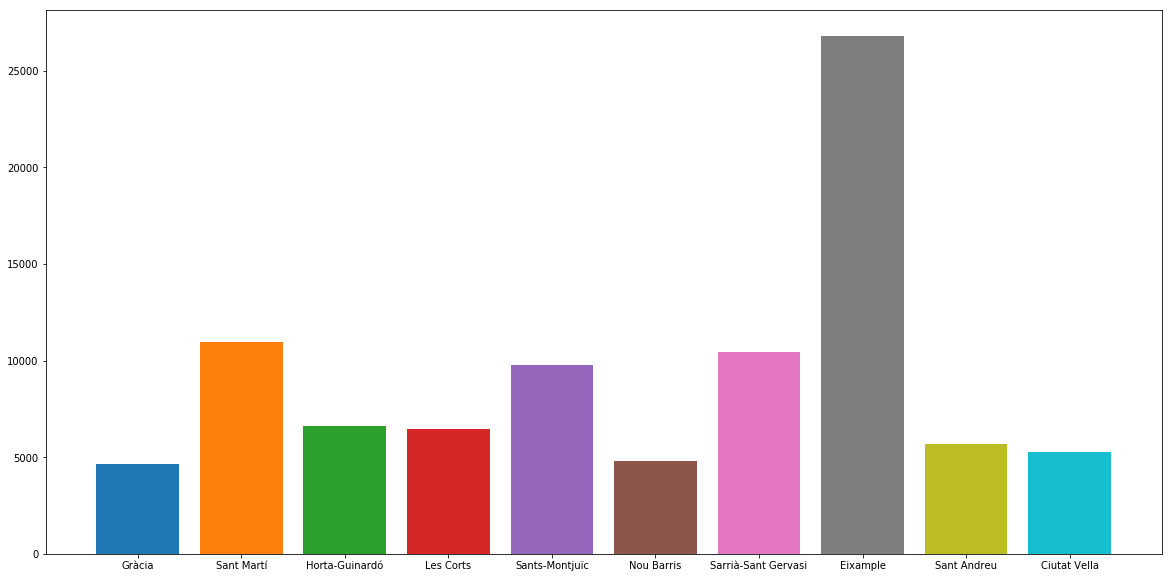

In [0]:
noms_districe = df.select("nom_districte").distinct().collect()
for nom in noms_districe:
  plt.bar(nom.nom_districte, df.filter(df.nom_districte == nom.nom_districte).count())
plt.show()

As we can see, most of the accidents happen at the Eixample. Of course, we should consider that there are districts bigger than others, so what we need to do now is to analyze the neighborhoods individually, but we will do it in the Eixample alone.

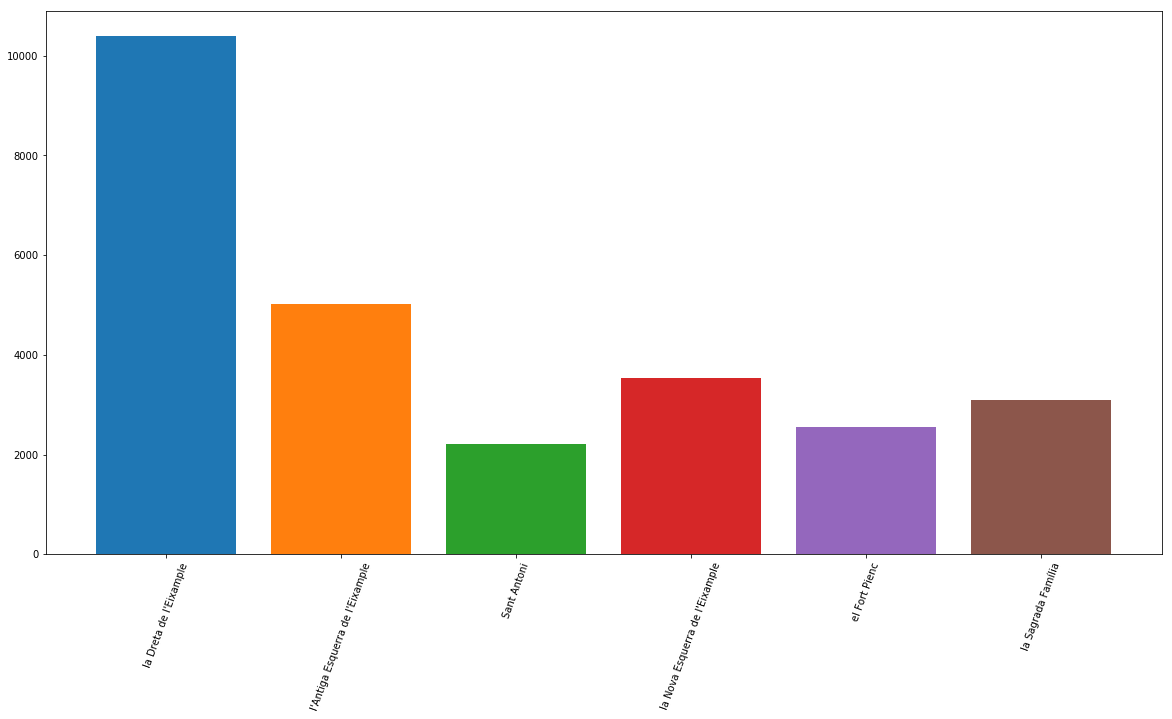

In [0]:
noms_barris = df.select("nom_barri").filter(df.nom_districte=="Eixample").distinct().collect()
for nom in noms_barris:
  plt.bar(nom.nom_barri, df.filter(df.nom_barri == nom.nom_barri).count())
plt.xticks(rotation=70)
plt.show()

So the neighborhood "La dreta de l'Eixample" is the one with more accidents. Let's see which street.

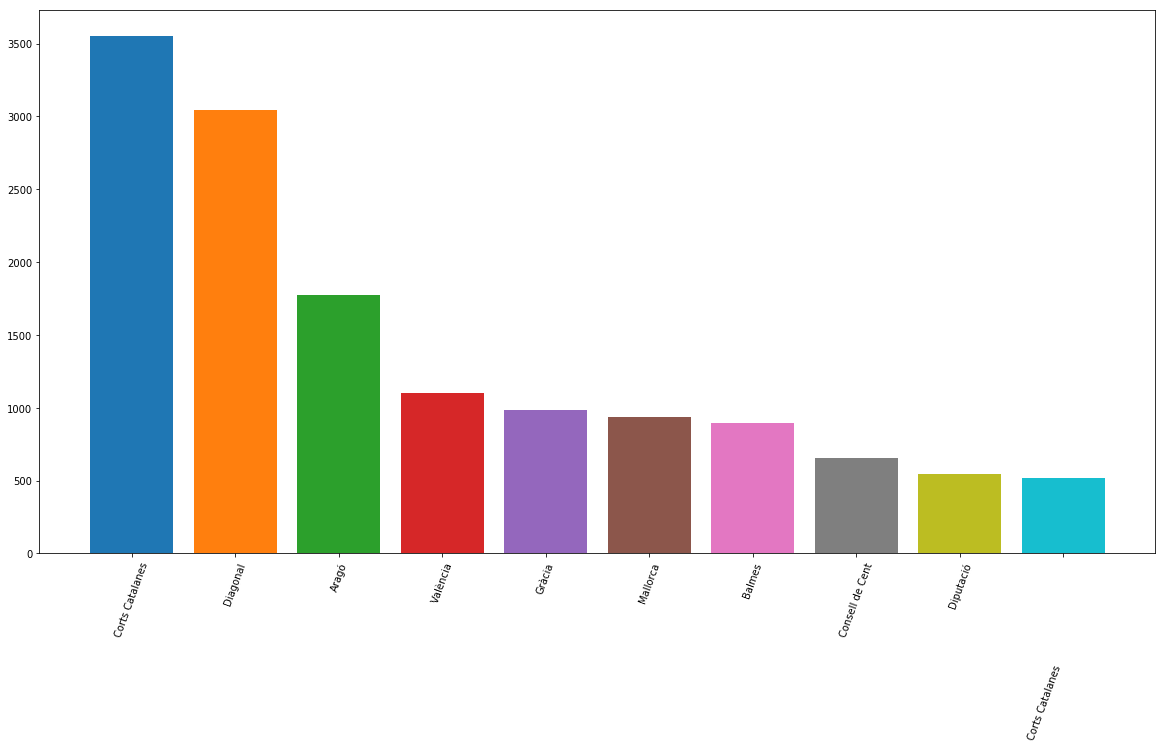

In [0]:
noms_carrers = df.select("nom_carrer").filter(df.nom_barri=="la Dreta de l'Eixample").distinct().collect()
carrers_info = []
for nom in noms_carrers:
  carrers_info.append((nom.nom_carrer, df.filter(df.nom_carrer == nom.nom_carrer).count()))

def foo(x):
  return x[1]
carrers_info.sort(reverse = True, key=foo)

for carrer in carrers_info[:10]:
  plt.bar(carrer[0], carrer[1])
plt.xticks(rotation=70)
plt.show()

The top 2 streets are really long and that's why the number of traffic accidents is also really big. Maybe these numbers would change if the accident/meter² is introduced.

# Now let's see the day of the week with more accidents..

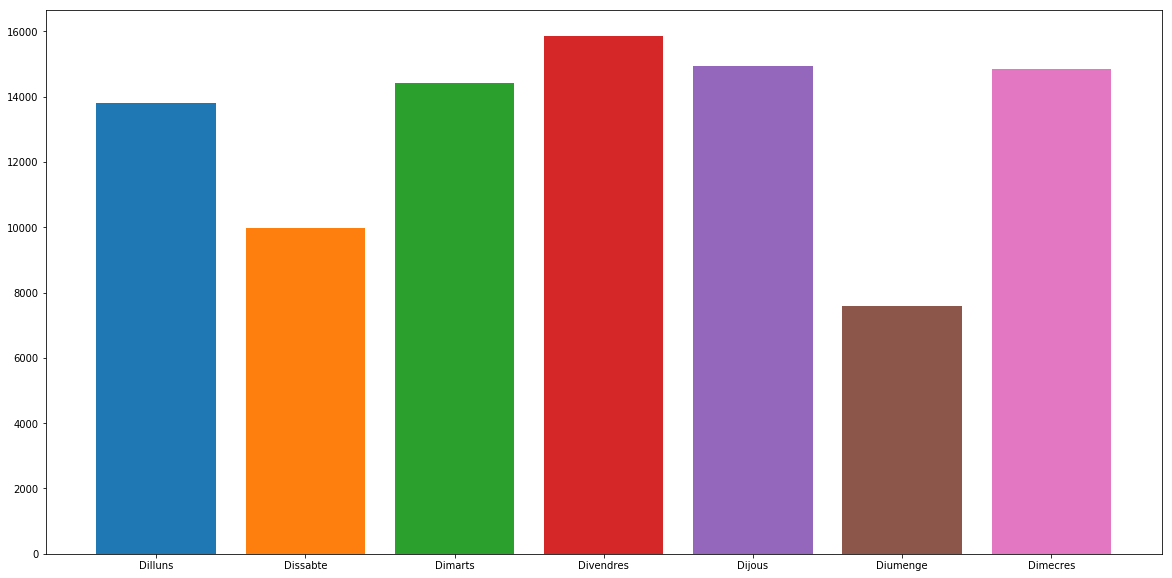

In [0]:
dies = df.select("descripcio_dia_setmana").distinct().collect()
for dia in dies:
  plt.bar(dia.descripcio_dia_setmana, df.filter(df.descripcio_dia_setmana == dia.descripcio_dia_setmana).count())
plt.show()

There are two things to take into account when analyzing this plot. First of all Friday, it's the top one, but the other days of the week are almost the same, minus Saturday and Sunday. We could say on weekend people tend to stay at home or don't use the vehicle to move, meaning the number of accidents decrease a lot.

Let's see which are the month with more accidents.


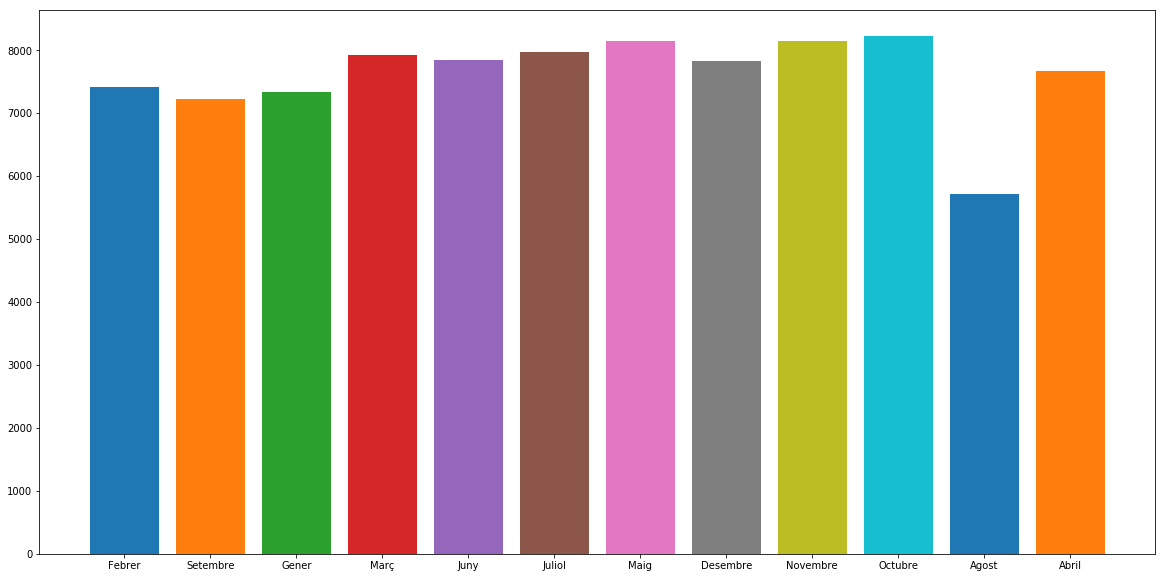

In [0]:
mesos = df.select("nom_mes").distinct().collect()
for mes in mesos:
  plt.bar(mes.nom_mes, df.filter(df.nom_mes == mes.nom_mes).count())
plt.show()

There is definetly something interesting from the plot above, the number of accidents remain more or less the same, but during august the number of accidents gets reduced by a 25%. The group assumes people is on holidays so they are not in the city during those days.


# At which hour? People tend to drive when going at work/home. Do accidents happen at that our?

In [0]:
df = df.withColumn("hora", df["hora"].cast('int'))

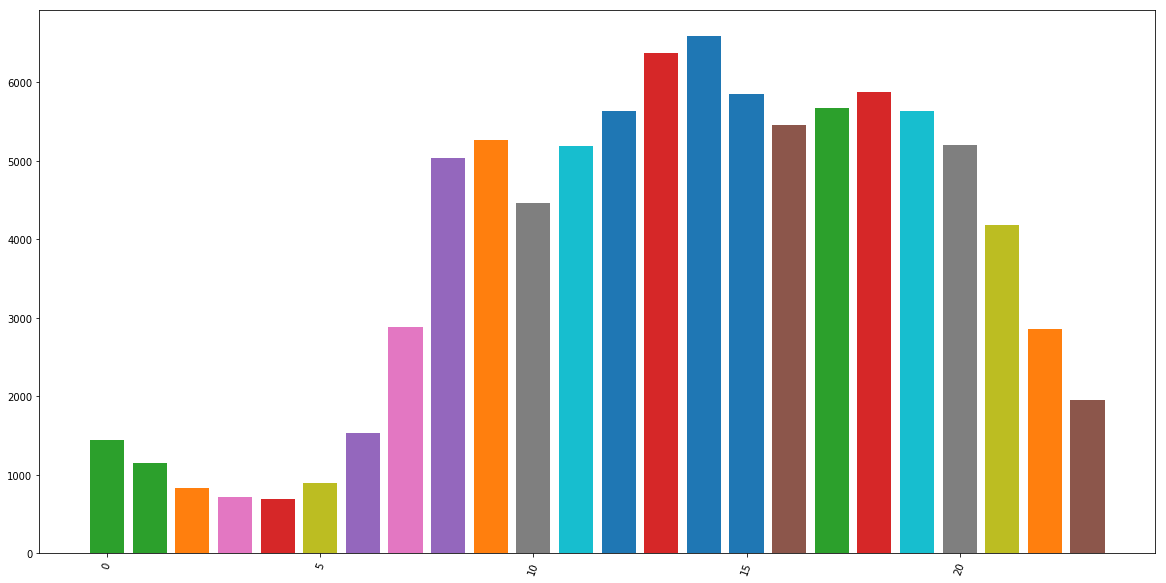

In [0]:
hores = df.select("hora").distinct().collect()
for hora in hores:
  plt.bar(hora.hora, df.filter(df.hora == hora.hora).count())
plt.xticks(rotation=70)
plt.show()

As we can see, the hour with most accidents is at 1-2pm. This means people that go lunch (from work) or teenagers that go home (highschools/university). 

# Now we will see the different kind of accidents

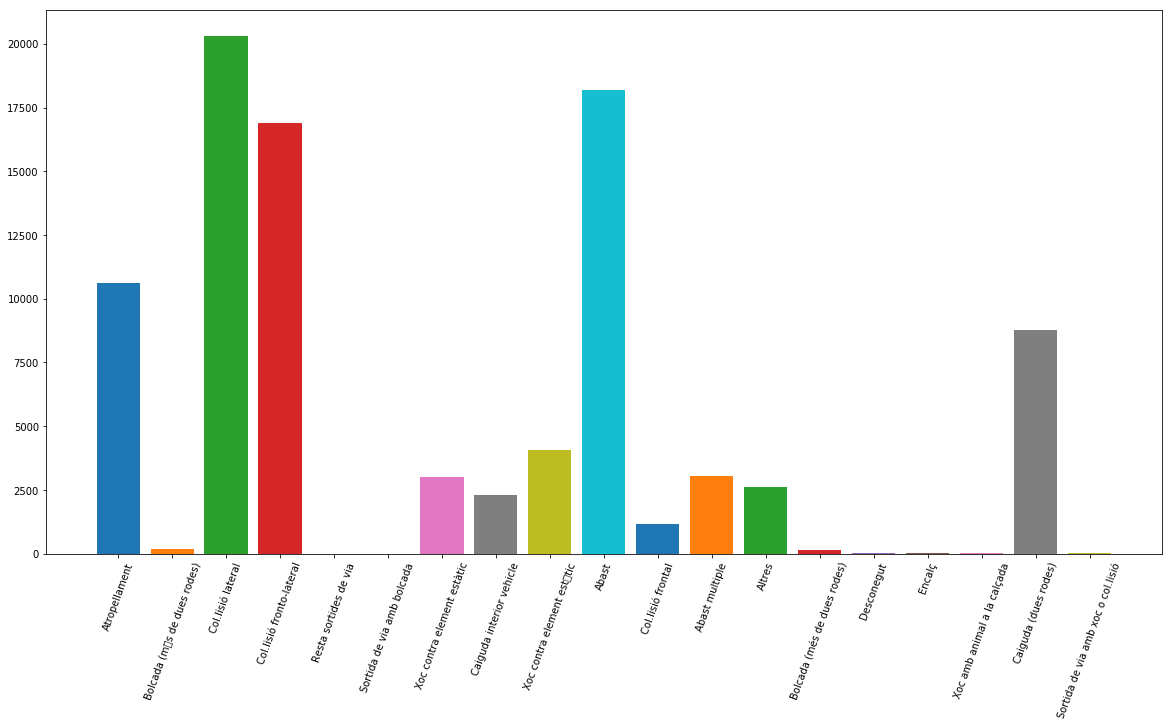

In [0]:
tipus = df.select("descripcio_tipus_accident").distinct().collect()
for tip in tipus:
  plt.bar(tip.descripcio_tipus_accident, df.filter(df.descripcio_tipus_accident == tip.descripcio_tipus_accident).count())
plt.xticks(rotation=70)
plt.show()

The majority of the accidents are because there is a collision, but it's also interesting the number of runovers. Clearly, the top ones are the collisions.

Until now we have:
- Majority of accidents happen at the example.
- Accidents happen more on Friday and less on Sunday.
- Majority of accidents are from collisions.
- Hours with more accidents.


# Finally, let's combine the hours with the location in order to check if accidents happen near univeristies or offices.

Pedralbes, La Maternitat i Sant Ramon, El Raval, and L'Antiga Esquerra de l'Eixample are the neighborhoods with more faculties, so we will study them. We can't identify any specific zone with a lot of people going there to work since there are offices in a lot of neighborhoods of Barcelona, we could do a specific study about this but it is not the aim of the project.

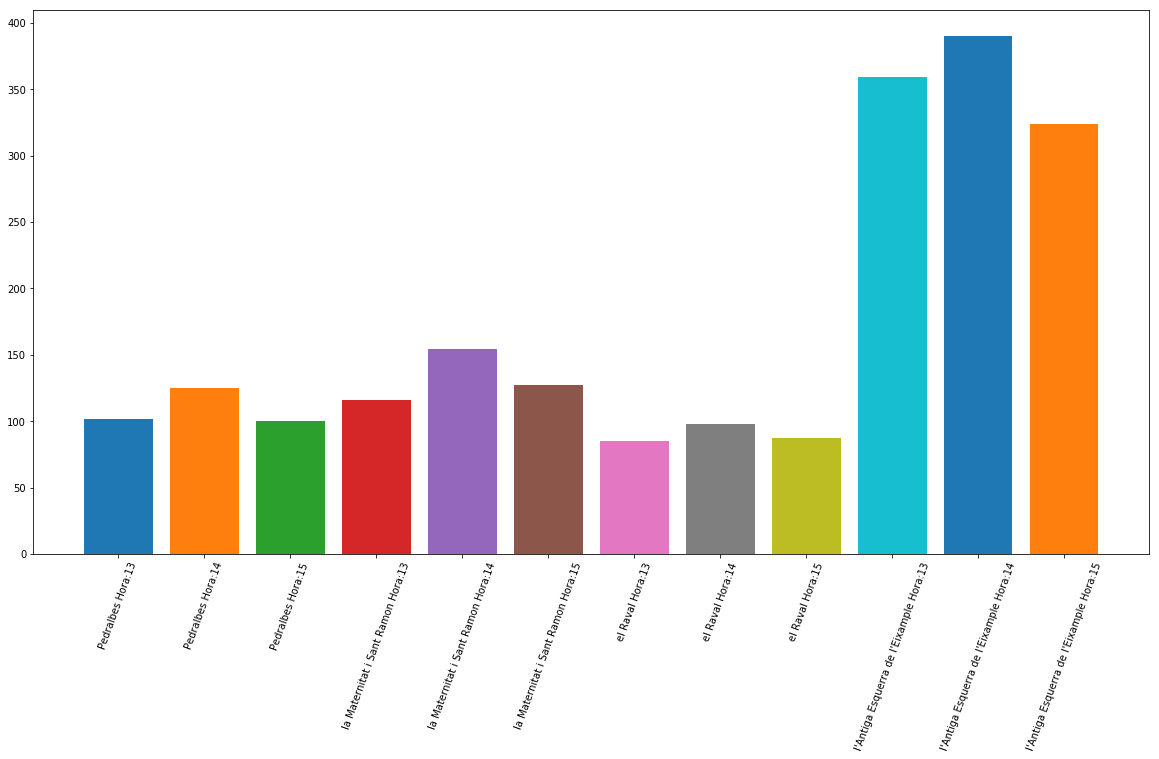

In [0]:
barris = ["Pedralbes", "la Maternitat i Sant Ramon", "el Raval", "l'Antiga Esquerra de l'Eixample"]
hores = [13,14,15]
for barri in barris:
  for hora in hores:
    plt.bar(barri+' Hora:'+str(hora), df.filter((df_.nom_barri == barri) & (df.hora == hora)).count())
plt.xticks(rotation=70)
plt.show()

As we can see the rates keep the same, being 2 pm the hour with more accidents, but the number of accidents in those neighborhoods is not high, meaning that the universities are not the main reason of having accidents in those hours.